# Figure 2
#### Christopher Callahan
#### Christopher.W.Callahan.GR@Dartmouth.edu

#### Mechanics
Import dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import seaborn as sns
import matplotlib.collections as collections
from scipy import stats

Data locations

In [2]:
loc_obs = "../Data/Probabilities/"
loc_lens = "../Data/Probabilities/LENS/"
loc_cmip = "../Data/Probabilities/CMIP5/"

Models and runs

In [3]:
runs = ["001","002","003","004","005","006","007","008","009", \
        "010","011","012","013","014","015","016","017","018", \
        "019","020","021","022","023","024","025","026","027", \
        "028","029","030","031","032","033","034","035"]

nruns = len(runs)

In [4]:
models = ["ACCESS1-0","ACCESS1-3","CNRM-CM5","GFDL-CM3","GFDL-ESM2M","GFDL-ESM2G","MIROC5","MIROC-ESM-CHEM","MRI-CGCM3","MRI-ESM1"]
nmodels = len(models)

#### Analysis

In [5]:
y1_met = 1981
y2_met = 2010
y1_aq = 2008
y2_aq = 2020

Read in obs probabilities for heat map

In [6]:
# haze given bins, etc
joint_probs_file = xr.open_dataset(loc_obs+"SOM_PC1_AQ_JOINT_PROBS_"+str(y1_aq)+"-"+str(y2_aq)+".nc")
joint_probs_obs = xr.DataArray(joint_probs_file.data_vars["PROBS"])
joint_probs_median = joint_probs_obs.median(dim="boot")
#haze_bins_flat = joint_probs_median.values.flatten()

# prob pc1/node
joint_occurrence_file = xr.open_dataset(loc_obs+"SOM_PC1_JOINT_OCCURRENCE_"+str(y1_met)+"-"+str(y2_met)+".nc")
joint_occurrence = xr.DataArray(joint_occurrence_file.data_vars["PROBS"])
joint_occurrence_median = joint_occurrence.median(dim="boot")

Read in modeled probabilities and calculate error

In [7]:
joint_occ_file_lens = xr.open_dataset(loc_lens+"LENS_SOM_PC1_JOINT_OCCURRENCE_BASELINE_"+str(y1_met)+"-"+str(y2_met)+".nc")
joint_occ_file_cmip = xr.open_dataset(loc_cmip+"CMIP5_SOM_PC1_JOINT_OCCURRENCE_BASELINE_"+str(y1_met)+"-"+str(y2_met)+".nc")

joint_occ_lens = xr.DataArray(joint_occ_file_lens.data_vars["FRACTION"])
joint_occ_cmip = xr.DataArray(joint_occ_file_cmip.data_vars["FRACTION"])

Calculate EM and error in the first (1981-2010) period

In [8]:
#joint_occ_lens_em = joint_occ_lens[:,0,:,:].mean(dim="run")
#joint_occ_cmip_em = joint_occ_cmip[:,0,:,:].mean(dim="model")
joint_occ_lens_em = joint_occ_lens.mean(dim="run")
joint_occ_cmip_em = joint_occ_cmip.mean(dim="model")

joint_occ_lens_error = joint_occ_lens_em - joint_occurrence_median.values
joint_occ_cmip_error = joint_occ_cmip_em - joint_occurrence_median.values

Significance test for error in the first period

In [9]:
joint_occ_lens_period = joint_occ_lens
joint_occ_cmip_period = joint_occ_cmip
joint_occ_lens_error_all = joint_occ_lens_period - joint_occurrence_median.values
joint_occ_cmip_error_all = joint_occ_cmip_period - joint_occurrence_median.values

lens_em_error_direction = (joint_occ_lens_error > 0).astype(int)
cmip_em_error_direction = (joint_occ_cmip_error > 0).astype(int)

lens_all_error_direction = ((joint_occ_lens_error_all > 0).astype(int)).mean(dim="run")
cmip_all_error_direction = ((joint_occ_cmip_error_all > 0).astype(int)).mean(dim="model")

lens_error_agreement = 1 - np.abs((lens_em_error_direction - lens_all_error_direction))
cmip_error_agreement = 1 - np.abs((cmip_em_error_direction - cmip_all_error_direction))

In [10]:
np.random.seed(100)
nboot = 100

In [11]:
nstd = 2
siglevel = 0.005
lens_significance = np.zeros((4,4))
cmip_significance = np.zeros((4,4))
lens_p = np.zeros((4,4))
cmip_p = np.zeros((4,4))

for jj in np.arange(0,4,1):
    for kk in np.arange(0,4,1):
        #obs_bin = joint_occurrence_median[jj,kk]
        obs_bin = joint_occurrence[jj,kk,:]
        lens_bin = joint_occ_lens_period[:,jj,kk]
        
        cmip_bin = joint_occ_cmip_period[:,jj,kk]
        [cmip_d, cmip_p[jj,kk]] = stats.ks_2samp(cmip_bin,obs_bin)
        if cmip_p[jj,kk] < siglevel:
            cmip_significance[jj,kk] = 1
        else:
            cmip_significance[jj,kk] = 0
            
        
        lens_p_boot = np.zeros(nboot)
        for nb in np.arange(0,nboot,1):
            
            lens_bin_subsample = lens_bin[np.random.randint(0,nruns,nmodels)]
            [lens_d, lens_p_boot[nb]] = stats.ks_2samp(lens_bin_subsample,obs_bin)
            #[lens_d, lens_p[jj,kk]] = stats.ks_2samp(lens_bin,obs_bin)
        
        lens_p[jj,kk] = np.median(lens_p_boot)
        
        if lens_p[jj,kk] < siglevel:
            lens_significance[jj,kk] = 1
        else:
            lens_significance[jj,kk] = 0
        
        
        
        #lens_mean = lens_bin.mean(dim="run")
        #lens_sd = nstd*(lens_bin.std(dim="run"))
        #cmip_mean = cmip_bin.mean(dim="model")
        #cmip_sd = nstd*(cmip_bin.std(dim="model"))
        
        
        #if ((obs_bin.values < (lens_mean - lens_sd)) | (obs_bin.values > (lens_mean+lens_sd))):
            #lens_significance[jj,kk] = 1
        #else:
            #lens_significance[jj,kk] = 0
        
        #if ((obs_bin.values < (cmip_mean - cmip_sd)) | (obs_bin.values > (cmip_mean+cmip_sd))):
            #cmip_significance[jj,kk] = 1
        #else:
            #cmip_significance[jj,kk] = 0

#### Plotting

In [12]:
# thanks to this stackoverflow post: https://stackoverflow.com/questions/44291155/plotting-two-distance-matrices-together-on-same-plot?noredirect=1&lq=1

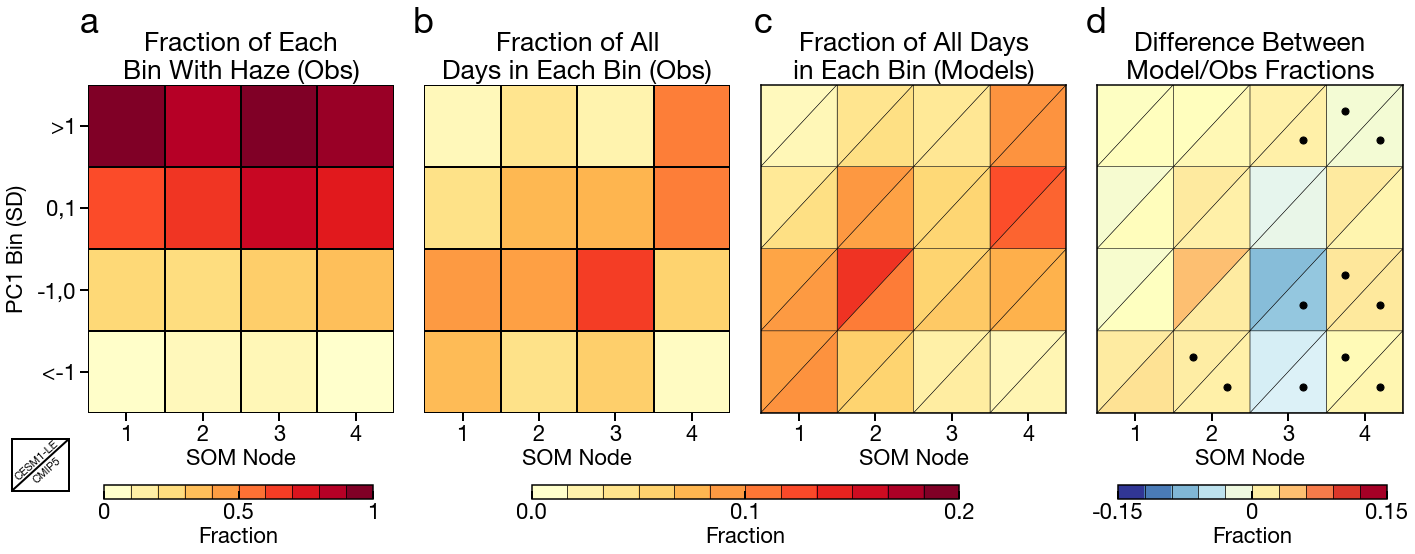

In [13]:
fig = plt.figure(figsize=(22,8))

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 22.0
rcParams["axes.linewidth"] = 1.5
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 2
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 2

gs1 = gridspec.GridSpec(1,4)
gs1.update(left=0.07,right=0.9,top=0.84,bottom=0.27,wspace=0.1,hspace=0.2)


## Percent of bin days that are haze days

ax = plt.subplot(gs1[0,0])

vmin = 0
vmax = 1.0
norm = colors.Normalize(vmin=vmin,vmax=vmax)
cbar = plt.cm.ScalarMappable(norm=norm,cmap=plt.cm.get_cmap("YlOrRd",10))

#ax.imshow(np.transpose(joint_probs_median[:,::-1].values))
sns.heatmap(np.transpose(joint_probs_median[:,::-1].values),linewidths=1,linecolor="black",cmap="YlOrRd",cbar=False,norm=norm,vmin=norm.vmin, vmax=norm.vmax) #,cbar_kws={'label': "Occurrence Probability", "drawedges":False})
plt.xticks(ticks=[0.5,1.5,2.5,3.5],labels=["1","2","3","4"])
plt.yticks(ticks=[3.5,2.5,1.5,0.5],labels=["<-1","-1,0","0,1",">1"])

plt.xlabel("SOM Node")
plt.ylabel("PC1 Bin (SD)",labelpad=10)

plt.title("Fraction of Each"+"\n"+"Bin With Haze (Obs)")
ax.tick_params(labelrotation=0)

# colorbar
cbar_ax = fig.add_axes([0.08, 0.12, 0.17, 0.025])
cb = fig.colorbar(cbar,cax=cbar_ax,orientation='horizontal',drawedges=True,extend="neither") #,shrink=0.5,pad=0.1)
cbar_ax.tick_params(direction="in")
#cb.set_ticks([0,0.1,0.2])
cb.set_ticks([0,0.5,1.0])
cb.set_ticklabels(["0","0.5","1"])
cb.set_label("Fraction")





## Joint occurrence of PC1 and SOM nodes

ax = plt.subplot(gs1[0,1])

vmin = 0
vmax = 0.2
norm = colors.Normalize(vmin=vmin,vmax=vmax)
cbar = plt.cm.ScalarMappable(norm=norm,cmap=plt.cm.get_cmap("YlOrRd",12))

#ax.imshow(np.transpose(joint_probs_median[:,::-1].values))
sns.heatmap(np.transpose(joint_occurrence_median[:,::-1].values),linewidths=1,linecolor="black",cmap="YlOrRd",cbar=False,norm=norm,vmin=norm.vmin, vmax=norm.vmax) #,cbar_kws={'label': "Occurrence Probability", "drawedges":False})
plt.xticks(ticks=[0.5,1.5,2.5,3.5],labels=["1","2","3","4"])
plt.yticks([])
#plt.yticks(ticks=[3.5,2.5,1.5,0.5],labels=["<-1","-1,0","0,1",">1"])

plt.xlabel("SOM Node")
#plt.ylabel([])

#plt.title("Probability of"+"\n"+"PC1/Node Bin")
plt.title("Fraction of All"+"\n"+"Days in Each Bin (Obs)")
ax.tick_params(labelrotation=0)

# colorbar
cbar_ax = fig.add_axes([0.35, 0.12, 0.27, 0.025])
cb = fig.colorbar(cbar,cax=cbar_ax,orientation='horizontal',drawedges=True,extend="neither") #,shrink=0.5,pad=0.1)
cbar_ax.tick_params(direction="in")
cb.set_ticks([0,0.1,0.2])
cb.set_label("Fraction")




ax = plt.subplot(gs1[0,2])


def triatpos(pos=(0,0), rot=0):
    r = np.array([[-1,-1],[1,-1],[1,1],[-1,-1]])*.5
    rm = [[np.cos(np.deg2rad(rot)), -np.sin(np.deg2rad(rot))],
           [np.sin(np.deg2rad(rot)),np.cos(np.deg2rad(rot)) ] ]
    r = np.dot(rm, r.T).T
    r[:,0] += pos[0]
    r[:,1] += pos[1]
    return r


colmap = "YlOrRd"
vmin = 0
vmax = 0.2
norm = colors.Normalize(vmin=vmin,vmax=vmax)
cbar = plt.cm.ScalarMappable(norm=norm,cmap=plt.cm.get_cmap(colmap,10))

def triamatrix(a, ax, rot=0, **kwargs):
    segs = []
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            segs.append(triatpos((j,i), rot=rot) )
    col = collections.PolyCollection(segs, cmap=colmap,norm=norm,edgecolors="black",linewidths=0.5)
    col.set_array(a.flatten())
    ax.add_collection(col)
    return col


#im1 = triamatrix(joint_occ_lens_em[::-1,::-1].values, ax, rot=180)
#im2 = triamatrix(joint_occ_cmip_em[::-1,::-1].values, ax, rot=0)

im1 = triamatrix(np.transpose(joint_occ_lens_em[:,:].values), ax, rot=180)
im2 = triamatrix(np.transpose(joint_occ_cmip_em[:,:].values), ax, rot=0)
plt.xticks(ticks=[0,1,2,3],labels=["1","2","3","4"])
plt.yticks([])
#plt.yticks(ticks=[0,1,2,3],labels=["<-1","-1,0","0,1",">1"])

plt.xlim([-0.5,3.5])
plt.ylim([-0.5,3.5])
plt.xlabel("SOM Node")
#plt.ylabel("PC1 Bin (SD)")
plt.title("Fraction of All Days"+"\n"+"in Each Bin (Models)")

# colorbar
#cbar_ax = fig.add_axes([0.5, 0.15, 0.15, 0.02])
#cb = fig.colorbar(cbar,cax=cbar_ax,orientation='horizontal',drawedges=True,extend="neither") #,shrink=0.5,pad=0.1)
#cbar_ax.tick_params(direction="in")
#cb.set_ticks([0,0.1,0.2])
#cb.set_label("Fraction")



ax = plt.subplot(gs1[0,3])


colmap = "RdYlBu_r"
vmin = -0.15
vmax = 0.15
norm = colors.Normalize(vmin=vmin,vmax=vmax)
cbar = plt.cm.ScalarMappable(norm=norm,cmap=plt.cm.get_cmap(colmap,10))

def triamatrix(a, ax, rot=0, **kwargs):
    segs = []
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            segs.append(triatpos((j,i), rot=rot) )
    col = collections.PolyCollection(segs, cmap=colmap,norm=norm,edgecolors="black",linewidths=0.5)
    col.set_array(a.flatten())
    ax.add_collection(col)
    return col

#im1 = triamatrix(joint_occ_lens_error[::-1,::-1].values, ax, rot=180)
#im2 = triamatrix(joint_occ_cmip_error[::-1,::-1].values, ax, rot=0)
im1 = triamatrix(np.transpose(joint_occ_lens_error[:,:].values), ax, rot=180)
im2 = triamatrix(np.transpose(joint_occ_cmip_error[:,:].values), ax, rot=0)

plt.xticks(ticks=[0,1,2,3],labels=["1","2","3","4"])
plt.yticks([])
#plt.yticks(ticks=[0,1,2,3],labels=["<-1","-1,0","0,1",">1"])

plt.xlim([-0.5,3.5])
plt.ylim([-0.5,3.5])
plt.xlabel("SOM Node")
#plt.ylabel("PC1 Bin (SD)")

plt.title("Difference Between"+"\n"+"Model/Obs Fractions")

# error significance dots
#lens_agreement = np.transpose(lens_error_agreement.values)
#cmip_agreement = np.transpose(cmip_error_agreement.values)
lens_sig = np.transpose(lens_significance)
cmip_sig = np.transpose(cmip_significance)
for jj in np.arange(0,4,1):
    for kk in np.arange(0,4,1):
        #if lens_agreement[jj,kk] < 0.75:
        #    plt.scatter(jj-0.25,kk+0.18,color="black",s=50)
        #if cmip_agreement[jj,kk] < 0.75:
        #    plt.scatter(jj+0.2,kk-0.18,color="black",s=50)
        if lens_sig[jj,kk] == 0:
            plt.scatter(jj-0.25,kk+0.18,color="black",s=50)
        if cmip_sig[jj,kk] == 0:
            plt.scatter(jj+0.2,kk-0.18,color="black",s=50)

# colorbar
cbar_ax = fig.add_axes([0.72, 0.12, 0.17, 0.025])
cb = fig.colorbar(cbar,cax=cbar_ax,orientation='horizontal',drawedges=True,extend="neither") #,shrink=0.5,pad=0.1)
cbar_ax.tick_params(direction="in")
cb.set_ticks([-0.15,0,0.15])
cb.set_ticklabels(["-0.15","0","0.15"])
cb.set_label("Fraction")








## Draw example box
box_ax = fig.add_axes([0.02,0.13,0.04,0.1])
plt.axhline(y=1,xmin=0.05,xmax=0.95,linewidth=2,linestyle="-",color="black")
plt.axhline(y=0,xmin=0.05,xmax=0.95,linewidth=2,linestyle="-",color="black")
plt.axvline(x=0,ymin=0.05,ymax=0.95,linewidth=2,linestyle="-",color="black")
plt.axvline(x=1,ymin=0.05,ymax=0.95,linewidth=2,linestyle="-",color="black")

plt.plot([0.02,0.98],[0.02,0.98],linewidth=2,color="black")

plt.text(0.02,0.2,"CESM1-LE",rotation=42,fontsize=11)
plt.text(0.33,0.15,"CMIP5",rotation=42,fontsize=11)

plt.axis('off')


## figtext

plt.figtext(0.065,0.93,"a",fontsize=35)
plt.figtext(0.275,0.93,"b",fontsize=35)
plt.figtext(0.49,0.93,"c",fontsize=35)
plt.figtext(0.7,0.93,"d",fontsize=35)



# plt.savefig("../Figures/Figure2.pdf")
plt.show()